In [337]:
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt

import tensorflow as tf

tf.compat.v1.enable_eager_execution()
AUTOTUNE = tf.data.AUTOTUNE

In [338]:
import pandas as pd
import numpy as np
import pathlib
import cv2
import os

### Paths

In [339]:
images_path = '../../../Dataset/img_celeba_cropped'
identity_path = '../../../Dataset/identity_CelebA.txt'
attributes_path = '../../../Dataset/list_attr_celeba.txt'

### Hyperparameters

In [340]:
images_num = 50
image_shape = (224, 224, 3)

batch_size = 5
lr=0.001

### Creating pairs

In [341]:
celeb_identity = pd.read_csv(identity_path, sep = " ", names=["image", "identity"])[:50000-1]
celeb_identity["identity"] = celeb_identity["identity"].astype("string")[:50000-1]

celeb_attrs = pd.read_csv(attributes_path, sep = "\s+")

In [342]:
def get_balanced_pair(column:str, pairing_column:str, df=celeb_identity):
    # getting random identity from the provided column to use for balanced pair
    random_id = df[column].sample(1, replace=True).to_string(index=False)
    containing_id_list = df.loc[df[column] == random_id][pairing_column].sample(2, replace=True).to_list()
    
    # random pictures for pair generation
    df_without_id = df.loc[df[pairing_column] != random_id]
    negative = df[pairing_column].sample(1, replace=False).to_list()
    
    return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative[0], 0]]

In [343]:
balanced_pairs = []

for record in range(images_num):
    pair = get_balanced_pair("identity", "image")
    balanced_pairs.append(pair[0])
    balanced_pairs.append(pair[1])
    
df = pd.DataFrame(balanced_pairs, columns =['left', 'right', 'label'])
df['left'] = images_path + '/' + df['left']
df['right'] = images_path + '/' + df['right']

In [344]:
df.shape

(100, 3)

### Loading pairs into TF Dataset

In [345]:
#dataset = tf.data.Dataset.from_tensor_slices((df['left'].values, df['right'].values, df['label'].values))

dataset_features = tf.data.Dataset.from_tensor_slices((df['left'].values, df['right'].values))

train_label_dataset = tf.data.Dataset.from_tensor_slices(df['label'].values)

In [313]:
def preprocessing(left, right):
        
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.expand_dims(img, axis=0)
    img = tf.reshape(img,(224,224,3))
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [314]:
dataset_features = dataset_features.map(preprocessing)
train_label_dataset = train_label_dataset.map(label_preprocessing)


dataset = tf.data.Dataset.zip((dataset_features, train_label_dataset))

dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [315]:
dataset.shuffle(1024)

<ShuffleDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [349]:
# krát 2, protože pokud máme 50 imagů, tak máme 100 párů

train_dataset = dataset.take(round(images_num * 2 * 0.8))
val_dataset = dataset.skip(round(images_num *2 * 0.8))

### Input layers

In [347]:
left_input = layers.Input(shape=(224, 224, 3), name='left_input')
right_input = layers.Input(shape=(224, 224, 3), name='right_input')

### VGG16 model

In [288]:
vgg16_left=vgg16.VGG16(
    input_tensor=left_input,
    include_top=False,
    input_shape=image_shape,
    pooling='avg',
    weights='imagenet',
    classes=2)

for layer in vgg16_left.layers[0:-1]:
    layer.trainable = False

    
output_layer_left = vgg16_left.output
    
model_left = Model(left_input, outputs=output_layer_left, name='resnet50_1')

In [289]:
vgg16_right=vgg16.VGG16(
    input_tensor=right_input,
    include_top=False,
    input_shape=image_shape,
    pooling='avg',
    weights='imagenet',
    classes=2)

for layer in vgg16_right.layers[0:-1]:
    layer.trainable = False
    
for layer in vgg16_right.layers:
    layer._name = layer.name + str('_2')

    
output_layer_right = vgg16_right.output
    
model_right = Model(right_input, outputs=output_layer_right, name='resnet50_2')

### Merging resnet branches layers

In [290]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [291]:
#merged = layers.subtract([left_vgg16, right_vgg16])
model = layers.Lambda(euclidean_distance, name="merge")([model_left.output, model_right.output])

#model = layers.Flatten()(merged)

model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(.2)(model)

model = layers.Dense(32, activation='relu')(model)
model = layers.Dropout(.2)(model)

model = layers.Dense(1, activation='sigmoid')(model)

model = Model(inputs = [left_input, right_input], outputs = model)

In [292]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

In [321]:
model.compile(optimizer=Adam(learning_rate=lr), loss=contrastive_loss_with_margin(margin=1.0), metrics=['accuracy'])

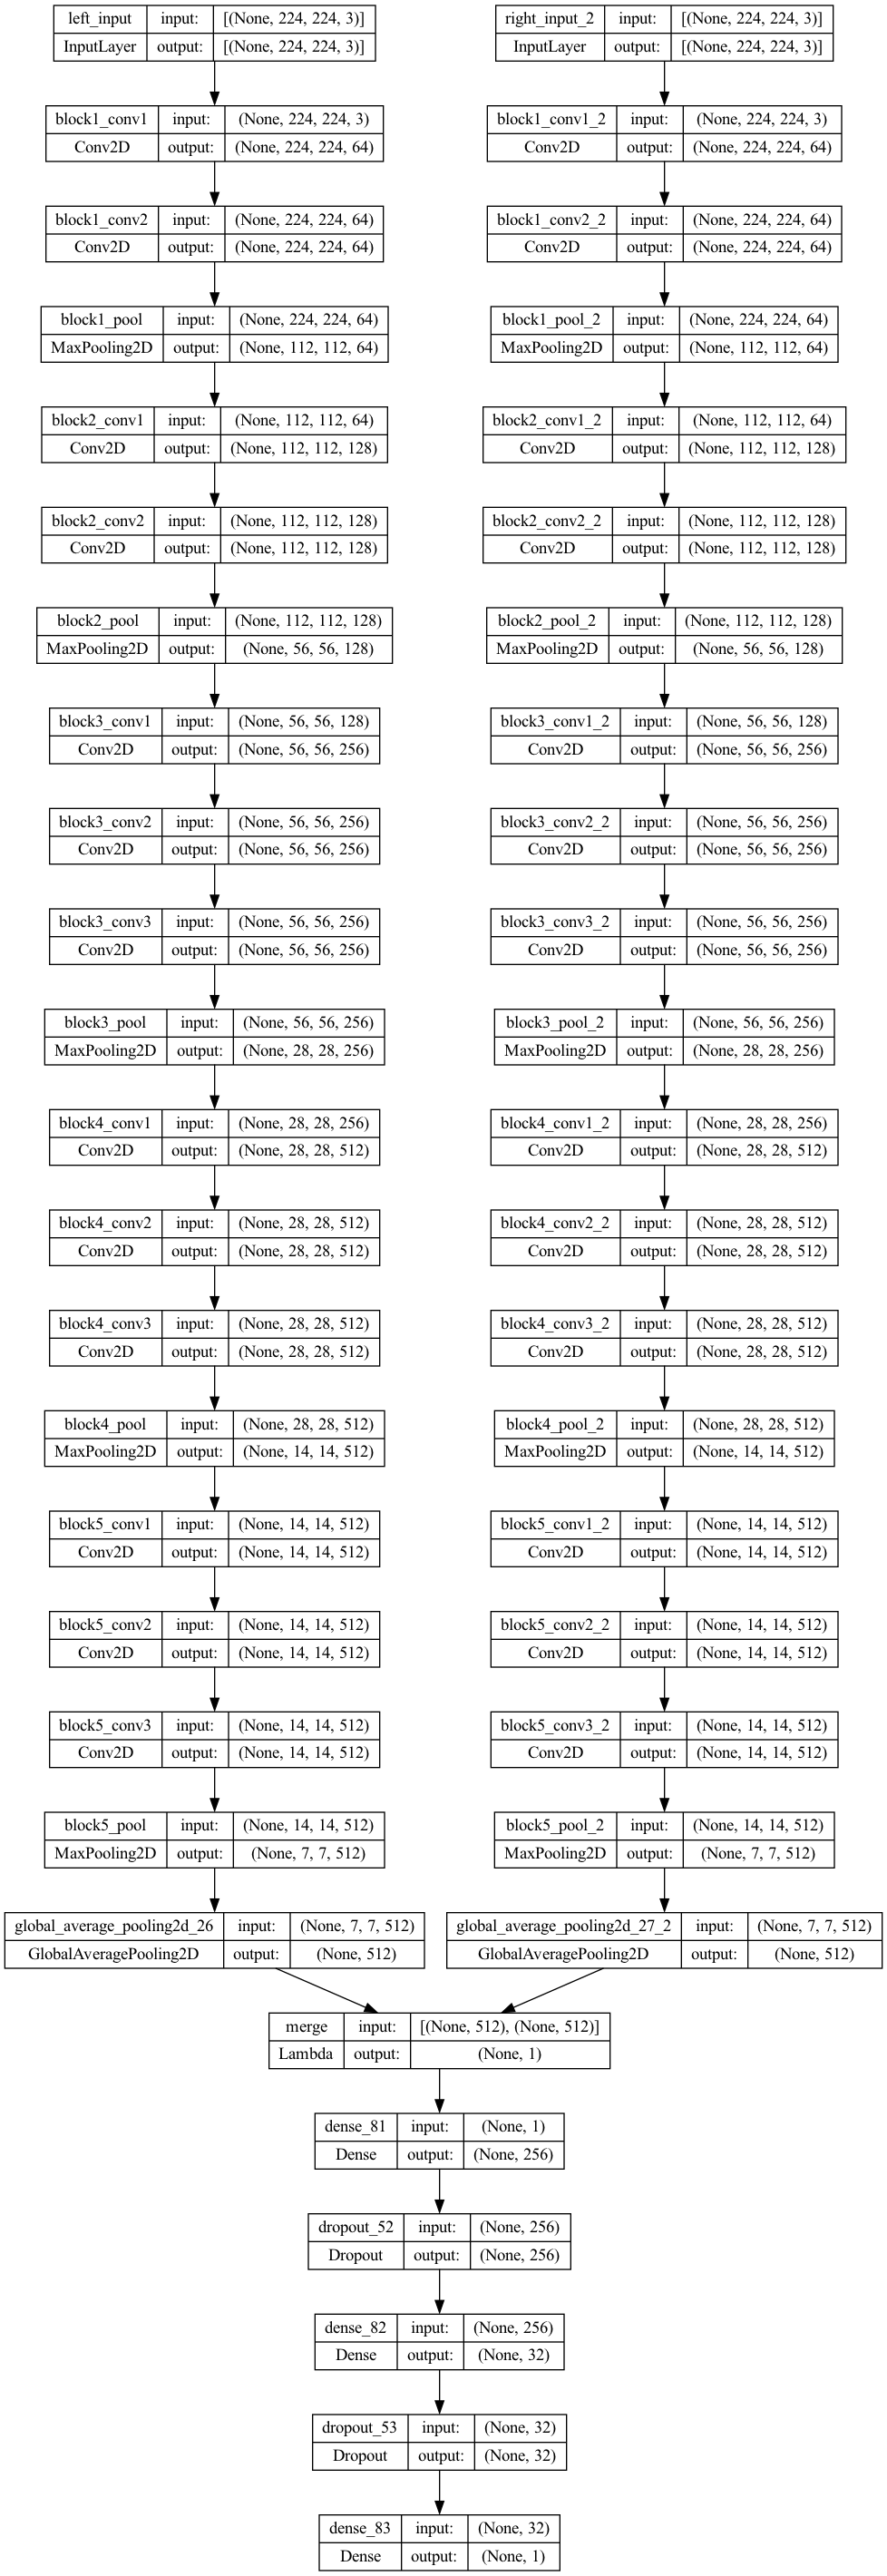

In [322]:
plot_model(model, show_shapes=True)
#model.summary()

In [350]:
model_fit = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
20/20 [==============================] - 2s 85ms/step - loss: 0.1800 - accuracy: 0.3300
Epoch 2/5
20/20 [==============================] - 2s 83ms/step - loss: 0.1793 - accuracy: 0.3300
Epoch 3/5
20/20 [==============================] - 2s 85ms/step - loss: 0.1797 - accuracy: 0.3300
Epoch 4/5
20/20 [==============================] - 2s 87ms/step - loss: 0.1788 - accuracy: 0.3200
Epoch 5/5
20/20 [==============================] - 2s 85ms/step - loss: 0.1791 - accuracy: 0.3300


### Performance metrics

In [335]:
print(model_fit.history.keys())

dict_keys(['loss', 'accuracy'])


KeyError: 'val_accuracy'

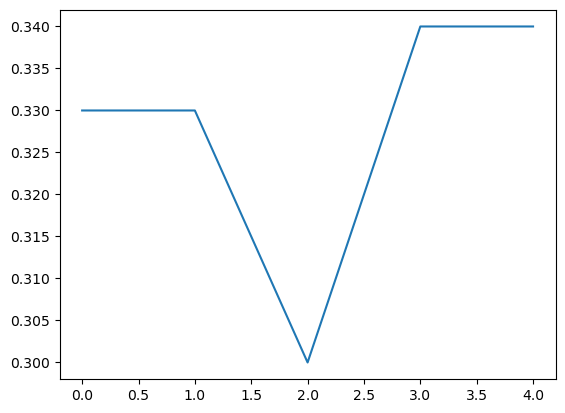

In [327]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0.5,ymax=1)
plt.grid()

plt.show()

KeyError: 'val_loss'

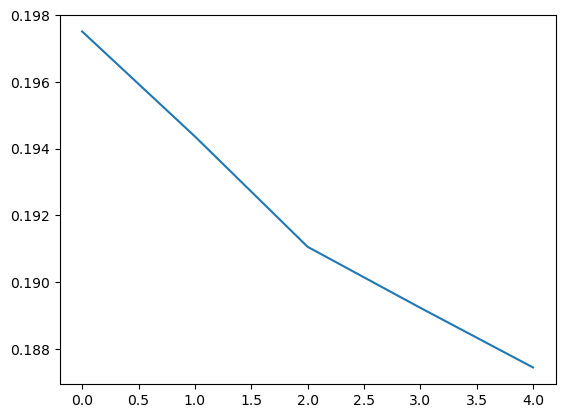

In [332]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=0.5)
plt.grid()

plt.show()

### Predictions

In [ ]:
left_image_feature_vectors = model.predict(custom_img_left)
left_image_feature_vectors = model.predict(custom_img_right)